In [1]:
# === Cell 1 — Libraries & Configuration ===
import numpy as np
import math, time, os, random
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd

# Ẩn cảnh báo font và chọn font hỗ trợ ký tự Unicode (subscript)
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
mpl.rcParams["font.family"] = "DejaVu Sans"

# Optional: seaborn style
try:
    import seaborn as sns
    sns.set(style="whitegrid")
except Exception:
    pass

mpl.rcParams.update({
    "figure.dpi": 140,
    "axes.spines.top": False,
    "axes.spines.right": False
})

# Seed, folder, and utility helpers
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)

def ensure_dir(path):
    d = os.path.dirname(path)
    if d:
        os.makedirs(d, exist_ok=True)

def savefig(path):
    ensure_dir(path)
    plt.tight_layout()
    plt.savefig(path, bbox_inches="tight")

# Global configuration
Config = {
    "dim": 10,
    "bounds": (-5.0, 5.0),
    "pop_size": 30,
    "max_iter": 800,
    "runs": 30,
    "cs_alpha": 0.01,
    "cs_pa": 0.25,
    "cs_beta": 1.5,
    "sa_T0": 1.0,
    "sa_alpha_T": 0.99,
    "ga_pop": 40,
    "ga_pc": 0.9,
    "ga_pm": 0.2,
}

set_seed(42)
os.makedirs("results/cont", exist_ok=True)
SUMMARY = {}


In [2]:
# === Cell 2 — Continuous Optimization Problems ===
def sphere(x):
    x = np.asarray(x)
    return float(np.sum(x ** 2))

def rastrigin(x):
    x = np.asarray(x)
    return float(10 * len(x) + np.sum(x ** 2 - 10 * np.cos(2 * np.pi * x)))

def rosenbrock(x):
    x = np.asarray(x)
    return float(np.sum(100 * (x[1:] - x[:-1] ** 2) ** 2 + (1 - x[:-1]) ** 2))

def ackley(x):
    x = np.asarray(x)
    n = len(x)
    s1 = np.sum(x ** 2) / n
    s2 = np.sum(np.cos(2 * np.pi * x)) / n
    return float(-20 * np.exp(-0.2 * np.sqrt(s1)) - np.exp(s2) + 20 + np.e)

CONTINUOUS_PROBLEMS = {
    "Sphere": {"fn": sphere, "lb": -5.0, "ub": 5.0},
    "Rastrigin": {"fn": rastrigin, "lb": -5.12, "ub": 5.12},
    "Rosenbrock": {"fn": rosenbrock, "lb": -5.0, "ub": 10.0},
    "Ackley": {"fn": ackley, "lb": -5.0, "ub": 5.0},
}


In [3]:
# === Cell 3 — Classic Baselines (HC, SA, GA) ===
def gaussian_neighbor(x, sigma=0.1, lb=None, ub=None):
    """Sinh lân cận Gaussian trong miền ràng buộc."""
    y = x + np.random.normal(0, sigma, x.shape)
    return np.clip(y, lb, ub) if lb is not None else y


class HillClimbContinuous:
    """Hill Climbing đơn giản cho bài toán continuous."""
    def __init__(self, func, x0, sigma=0.1, lb=None, ub=None, max_iter=500):
        self.func, self.x, self.sigma = func, x0.copy(), sigma
        self.lb, self.ub, self.max_iter = lb, ub, int(max_iter)
        self.fx = float(self.func(self.x))

    def run(self):
        hist = [self.fx]
        for _ in range(self.max_iter):
            cand = gaussian_neighbor(self.x, self.sigma, self.lb, self.ub)
            f2 = float(self.func(cand))
            if f2 < self.fx:
                self.x, self.fx = cand, f2
            hist.append(self.fx)
        return np.asarray(hist), self.x.copy(), float(self.fx)


class SAContinuous:
    """Simulated Annealing cho continuous optimization."""
    def __init__(self, func, x0, T0=1.0, alpha_T=0.99, sigma=0.1, lb=None, ub=None, max_iter=500):
        self.func, self.x = func, x0.copy()
        self.T, self.alpha_T, self.sigma = float(T0), float(alpha_T), float(sigma)
        self.lb, self.ub, self.max_iter = lb, ub, int(max_iter)
        self.fx = float(self.func(self.x))

    def run(self):
        hist = [self.fx]
        for _ in range(self.max_iter):
            cand = gaussian_neighbor(self.x, self.sigma, self.lb, self.ub)
            f2 = float(self.func(cand))
            if (f2 < self.fx) or (np.random.rand() < math.exp((self.fx - f2) / max(self.T, 1e-12))):
                self.x, self.fx = cand, f2
            self.T *= self.alpha_T
            hist.append(self.fx)
        return np.asarray(hist), self.x.copy(), float(self.fx)


class GAContinuous:
    """Genetic Algorithm chuẩn hóa cho continuous search."""
    def __init__(self, func, dim, lb, ub, pop=40, pc=0.9, pm=0.2, max_iter=500):
        self.func, self.dim = func, int(dim)
        self.lb, self.ub = np.full(self.dim, lb), np.full(self.dim, ub)
        self.pop, self.pc, self.pm, self.max_iter = int(pop), float(pc), float(pm), int(max_iter)
        self.X = self.lb + (self.ub - self.lb) * np.random.rand(self.pop, self.dim)
        self.fit = np.apply_along_axis(self.func, 1, self.X)

    def _select(self):
        i1 = np.random.randint(0, self.pop, self.pop)
        i2 = np.random.randint(0, self.pop, self.pop)
        return self.X[np.where(self.fit[i1] < self.fit[i2], i1, i2)]

    def _crossover(self, P):
        C = P.copy()
        for i in range(0, self.pop, 2):
            if np.random.rand() < self.pc and i + 1 < self.pop:
                a = np.random.rand()
                C[i], C[i + 1] = a * P[i] + (1 - a) * P[i + 1], a * P[i + 1] + (1 - a) * P[i]
        return np.clip(C, self.lb, self.ub)

    def _mutate(self, X):
        mask = np.random.rand(*X.shape) < (self.pm / self.dim)
        return np.clip(X + mask * np.random.normal(0, 0.1, X.shape) * (self.ub - self.lb), self.lb, self.ub)

    def run(self):
        hist = [self.fit.min()]
        for _ in range(self.max_iter):
            P = self._select()
            C = self._crossover(P)
            M = self._mutate(C)
            self.X = M
            self.fit = np.apply_along_axis(self.func, 1, self.X)
            hist.append(self.fit.min())
        i = int(np.argmin(self.fit))
        return np.asarray(hist), self.X[i].copy(), float(self.fit[i])


In [4]:
# === Cell 4 — Advanced Cuckoo Search (adaptive, recombination, opposition) ===
def levy_flight(dim, beta=1.5):
    sigma_u = ((math.gamma(1 + beta) * math.sin(math.pi * beta / 2)) /
               (math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))) ** (1 / beta)
    u = np.random.normal(0, sigma_u, size=dim)
    v = np.random.normal(0, 1, size=dim)
    return u / (np.abs(v) ** (1 / beta) + 1e-12)


class CuckooSearchContinuous:
    """Improved Cuckoo Search (adaptive α, pₐ, recombination, local walk, opposition)."""

    def __init__(self, func, dim=10, lb=-5, ub=5, n=30, alpha=0.01, pa=0.25, beta=1.5,
                 max_iter=500, seed=None, patience=60, restarts=1):
        if seed is not None:
            set_seed(seed)
        self.func, self.dim = func, int(dim)
        self.lb, self.ub = np.full(dim, lb), np.full(dim, ub)
        self.range = self.ub - self.lb
        self.n, self.alpha0, self.pa, self.beta = int(n), float(alpha), float(pa), float(beta)
        self.max_iter, self.patience, self.restarts = int(max_iter), int(patience), int(restarts)
        self.X = self.lb + self.range * np.random.rand(self.n, self.dim)
        self.F = np.apply_along_axis(self.func, 1, self.X)
        i = int(np.argmin(self.F))
        self.best_x, self.best_f = self.X[i].copy(), float(self.F[i])

    # --- Utility ---
    def _clip(self, X): return np.clip(X, self.lb, self.ub)
    def _diversity(self): return float(np.mean(np.std(self.X, axis=0) / (self.range + 1e-12)))

    def _alpha(self, t, div):
        base = self.alpha0 * (1 - t / max(1, self.max_iter)) ** 0.35
        return base * (1.0 + 0.5 * max(0.0, 0.15 - div) / 0.15)

    def _pa(self, div):
        return float(np.clip(self.pa + (0.25 * max(0.0, 0.15 - div) / 0.15), 0.15, 0.45))

    # --- Operators ---
    def _recombine(self, X):
        if np.random.rand() > 0.2: return X
        idx = np.random.permutation(self.n)
        for a, b in zip(idx[::2], idx[1::2]):
            w = np.random.rand()
            X[a] = w * X[a] + (1 - w) * X[b]
        return self._clip(X)

    def _local_walk(self, a_t):
        eps = np.random.normal(0, 0.25, size=self.X.shape) * (np.std(self.X, axis=0, keepdims=True) + 1e-12)
        return self._clip(self.X + a_t * eps)

    def _opposition(self, Xw):
        x_op = self.lb + self.ub - Xw
        return self._clip(np.where(np.random.rand(*Xw.shape) < 0.5, Xw, x_op))

    def _abandon(self, pa_dyn):
        k = max(1, int(pa_dyn * self.n))
        worst = np.argpartition(self.F, -k)[-k:]
        Xcand1 = self.lb + self.range * np.random.rand(k, self.dim)
        Xcand2 = self._opposition(self.X[worst])
        Xnew = np.where(np.random.rand(k, 1) < 0.5, Xcand1, Xcand2)
        Fnew = np.apply_along_axis(self.func, 1, Xnew)
        self.X[worst], self.F[worst] = Xnew, Fnew

    def _update_best(self):
        i = int(np.argmin(self.F))
        if self.F[i] < self.best_f:
            self.best_x, self.best_f = self.X[i].copy(), float(self.F[i])

    # --- Main Loop ---
    def run(self, max_iter=None):
        T = max_iter or self.max_iter
        hist, best_keep, no_imp, restart_done = [], self.best_f, 0, 0
        for it in range(T):
            div = self._diversity()
            a_t, pa_dyn = self._alpha(it, div), self._pa(div)

            steps = np.array([levy_flight(self.dim, self.beta) for _ in range(self.n)])
            Xg = self._clip(self.X + a_t * steps * (self.X - self.best_x))
            Xg = self._recombine(Xg)
            Fg = np.apply_along_axis(self.func, 1, Xg)
            better = Fg < self.F
            if np.any(better): self.X[better], self.F[better] = Xg[better], Fg[better]

            Xl = self._local_walk(a_t * 0.6)
            Fl = np.apply_along_axis(self.func, 1, Xl)
            better = Fl < self.F
            if np.any(better): self.X[better], self.F[better] = Xl[better], Fl[better]

            self._abandon(pa_dyn); self._update_best()
            j = int(np.argmax(self.F))
            self.X[j], self.F[j] = self.best_x.copy(), self.best_f

            hist.append(self.best_f)
            if self.best_f + 1e-12 < best_keep: best_keep, no_imp = self.best_f, 0
            else:
                no_imp += 1
                if no_imp >= self.patience and restart_done < self.restarts:
                    radius = 0.12
                    self.X = self._clip(self.best_x + radius * (np.random.rand(self.n, self.dim) - 0.5) * self.range)
                    self.F = np.apply_along_axis(self.func, 1, self.X)
                    self._update_best(); no_imp = 0; restart_done += 1
        return np.asarray(hist), self.best_x.copy(), float(self.best_f)


In [5]:
# === Cell 5 — Auto-tuner for CS (alpha, pa, pop, beta) ===
def tune_cs_params(fn, lb, ub, dim=10, max_iter=400, trials=3,
                   alpha_list=(0.003, 0.01, 0.02, 0.03, 0.05),
                   pa_list=(0.15, 0.20, 0.25, 0.30, 0.35),
                   pop_list=(30, 40, 50, 60),
                   beta_list=(1.2, 1.5, 1.8)):
    """
    Grid-search tham số cho Cuckoo Search.
    Trả về cấu hình alpha, pa, pop, beta có mean fitness nhỏ nhất.
    """
    best_cfg, best_mean = None, float("inf")
    for alpha in alpha_list:
        for pa in pa_list:
            for pop in pop_list:
                for beta in beta_list:
                    vals = []
                    for r in range(trials):
                        cs = CuckooSearchContinuous(fn, dim, lb, ub, n=pop,
                                                    alpha=alpha, pa=pa, beta=beta,
                                                    max_iter=max_iter, seed=777 + r)
                        _, _, f = cs.run()
                        vals.append(f)
                    mean_val = float(np.mean(vals))
                    if mean_val < best_mean:
                        best_mean, best_cfg = mean_val, {
                            "alpha": alpha, "pa": pa, "pop": pop, "beta": beta
                        }
    return best_cfg



Problem: Sphere
Chosen CS params: alpha=0.05, pa=0.15, pop=30, beta=1.2


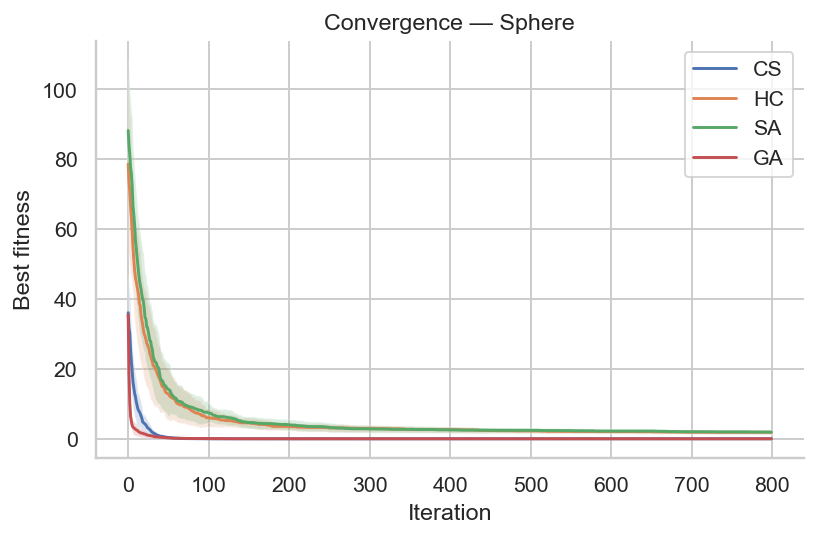

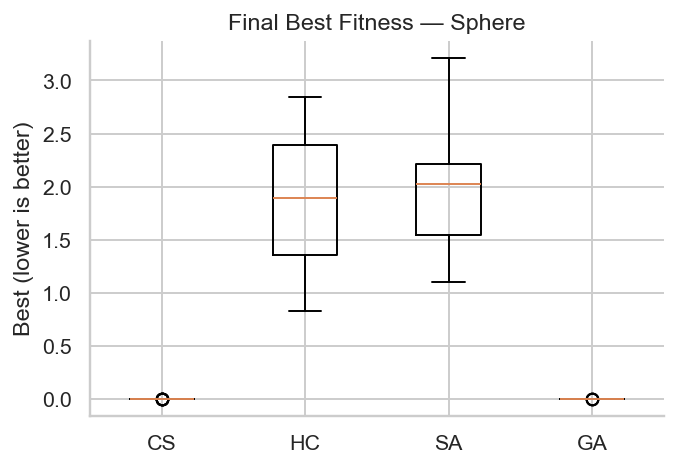


Problem: Rastrigin
Chosen CS params: alpha=0.02, pa=0.3, pop=30, beta=1.5


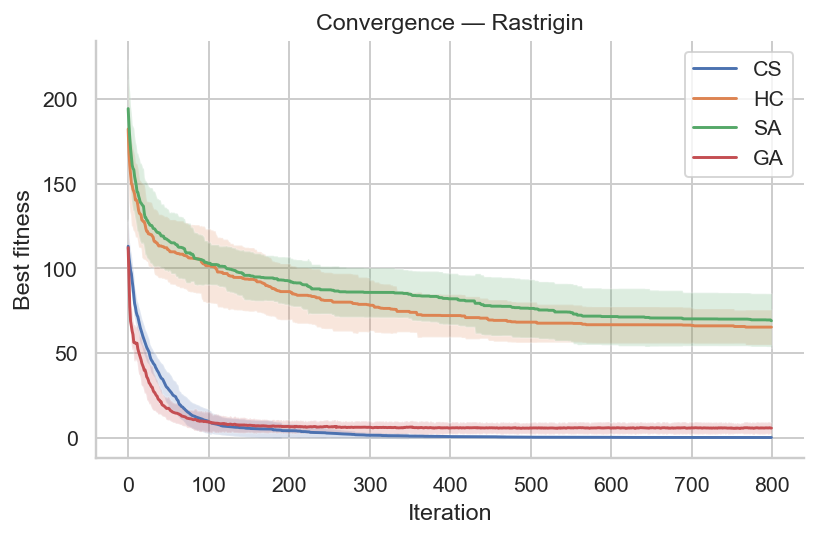

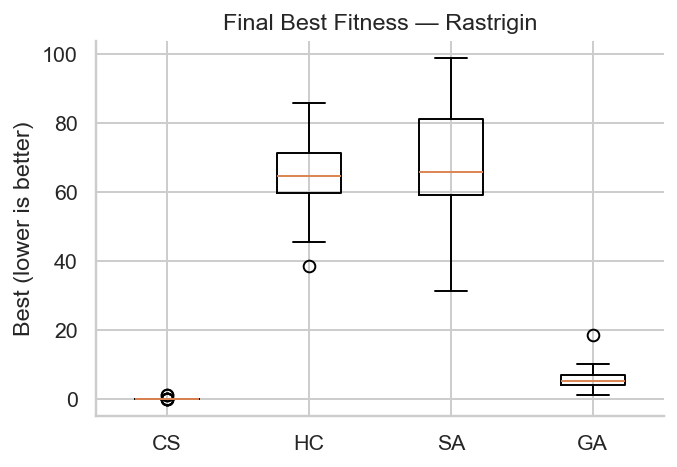


Problem: Rosenbrock
Chosen CS params: alpha=0.05, pa=0.15, pop=60, beta=1.5


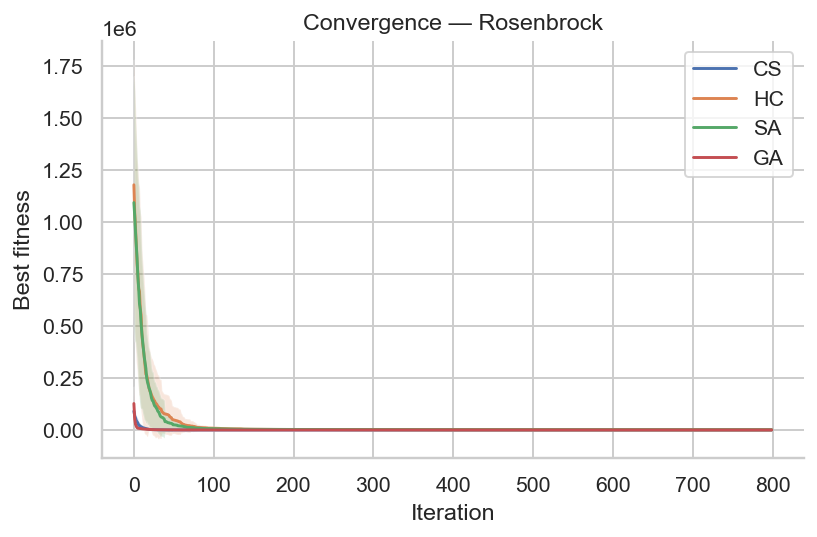

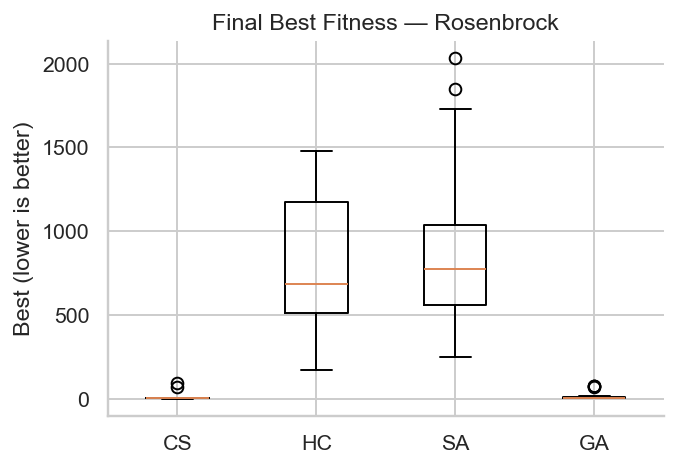


Problem: Ackley
Chosen CS params: alpha=0.003, pa=0.3, pop=30, beta=1.5


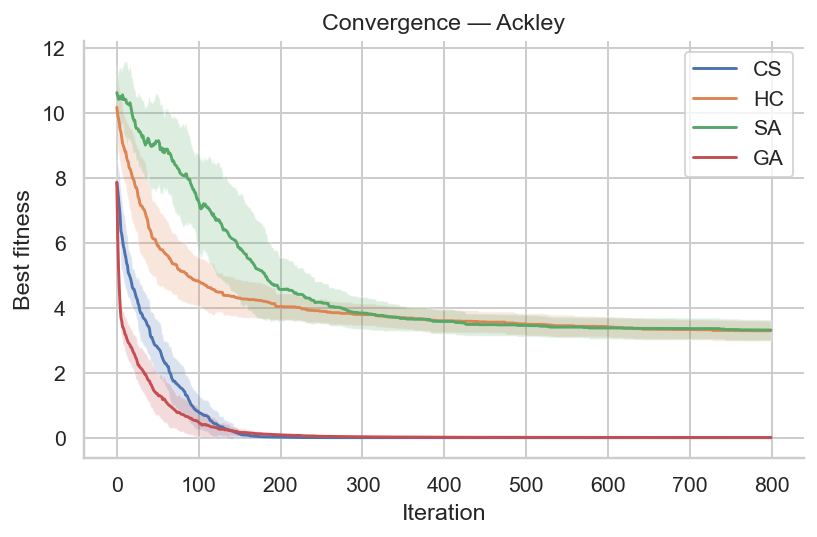

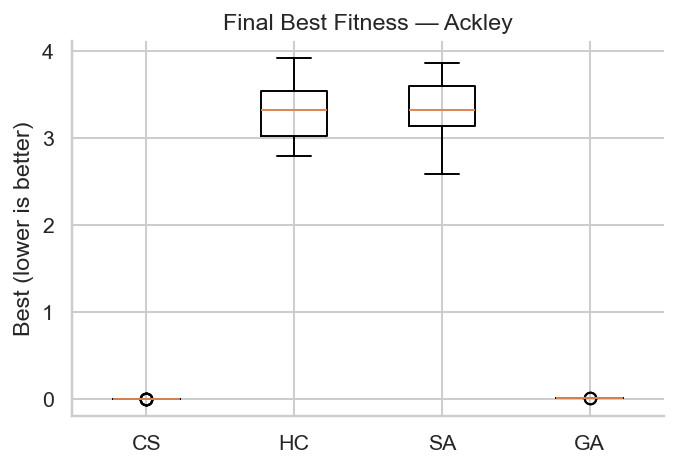

In [6]:
# === Cell 6 — Experiments: CS (tuned) vs HC/SA/GA (FA-style) ===
import os, shutil
ensure_dir("results/cont/")
os.makedirs("figures", exist_ok=True)  # nơi LaTeX sẽ lấy ảnh

for pname, spec in CONTINUOUS_PROBLEMS.items():
    fn, lb, ub = spec["fn"], spec["lb"], spec["ub"]
    print(f"\n==============================")
    print(f"Problem: {pname}")
    print(f"==============================")

    cfg = tune_cs_params(fn, lb, ub, dim=Config["dim"], max_iter=400, trials=2)
    alpha, pa, pop, beta = cfg["alpha"], cfg["pa"], cfg["pop"], cfg["beta"]
    print(f"Chosen CS params: alpha={alpha}, pa={pa}, pop={pop}, beta={beta}")

    results = {"CS": [], "HC": [], "SA": [], "GA": []}

    # --- chạy các thuật toán ---
    for r in range(Config["runs"]):
        seed = 1000 + r
        set_seed(seed)

        cs = CuckooSearchContinuous(fn, Config["dim"], lb, ub, n=pop,
                                    alpha=alpha, pa=pa, beta=beta,
                                    max_iter=Config["max_iter"], seed=seed)
        hc = HillClimbContinuous(fn, lb + (ub - lb) * np.random.rand(Config["dim"]),
                                 sigma=0.1 * (ub - lb),
                                 lb=np.full(Config["dim"], lb), ub=np.full(Config["dim"], ub),
                                 max_iter=Config["max_iter"])
        sa = SAContinuous(fn, lb + (ub - lb) * np.random.rand(Config["dim"]),
                          T0=Config["sa_T0"], alpha_T=Config["sa_alpha_T"], sigma=0.1 * (ub - lb),
                          lb=np.full(Config["dim"], lb), ub=np.full(Config["dim"], ub),
                          max_iter=Config["max_iter"])
        ga = GAContinuous(fn, Config["dim"], lb, ub,
                          pop=Config["ga_pop"], pc=Config["ga_pc"], pm=Config["ga_pm"],
                          max_iter=Config["max_iter"])

        for name, algo in [("CS", cs), ("HC", hc), ("SA", sa), ("GA", ga)]:
            t0 = time.time()
            hist, _, f = algo.run()
            t = time.time() - t0
            results[name].append({"f": f, "hist": hist, "t": t})

    # --- Biểu đồ hội tụ ---
    L = min(len(x["hist"]) for v in results.values() for x in v)
    plt.figure(figsize=(6, 4))
    for name, arr in results.items():
        H = np.vstack([x["hist"][:L] for x in arr])
        m, s = H.mean(axis=0), H.std(axis=0)
        plt.plot(m, label=name)
        plt.fill_between(np.arange(L), m - s, m + s, alpha=0.2)
    plt.title(f"Convergence — {pname}")
    plt.xlabel("Iteration"); plt.ylabel("Best fitness"); plt.legend()
    path_conv = f"results/cont/{pname}_convergence.png"
    savefig(path_conv); plt.show()

    # đồng bộ ảnh chuẩn sang ./figures với naming cố định cho LaTeX
    shutil.copy2(path_conv, f"figures/cs_convergence_{pname.lower()}.png")

    # --- Boxplot kết quả cuối ---
    plt.figure(figsize=(5, 3.5))
    try:
        plt.boxplot([[x["f"] for x in results[a]] for a in results.keys()],
                    tick_labels=list(results.keys()))
    except TypeError:
        plt.boxplot([[x["f"] for x in results[a]] for a in results.keys()],
                    labels=list(results.keys()))
    plt.title(f"Final Best Fitness — {pname}")
    plt.ylabel("Best (lower is better)")
    path_box = f"results/cont/{pname}_boxplot.png"
    savefig(path_box); plt.show()

    shutil.copy2(path_box, f"figures/cs_boxplot_{pname.lower()}.png")

    # --- Ghi tóm tắt ---
    stats = {}
    for a, arr in results.items():
        bests = np.array([x["f"] for x in arr])
        times = np.array([x["t"] for x in arr])
        stats[a] = {
            "mean": float(bests.mean()),
            "std": float(bests.std()),
            "time": float(times.mean())
        }

    SUMMARY[pname] = {"CS_params": cfg, "stats": stats}


Saved trajectory figure: figures/cs_trajectory_rastrigin.png


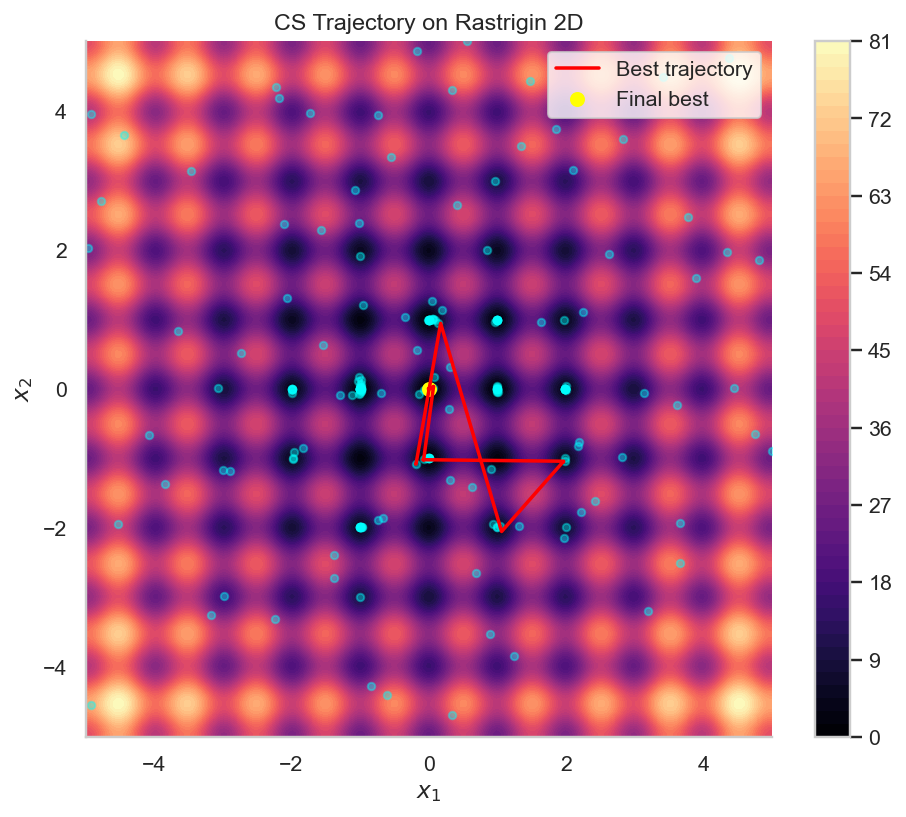

In [7]:
# === Cell 7 — Visualizer (2D Rastrigin, fixed and save trajectory figure) ===
def visualize_cs_2d(func, lb=-5, ub=5, n=25, iters=150, seed=42, save_path=None):
    """
    Vẽ quá trình hội tụ của Cuckoo Search (CS) trên hàm 2D.
    Bao gồm chuyển động của quần thể (n cá thể) theo các iteration.
    """
    set_seed(seed)
    cs = CuckooSearchContinuous(func=func, dim=2, lb=lb, ub=ub, n=n,
                                alpha=0.02, pa=0.25, beta=1.5,
                                max_iter=iters, seed=seed)

    # Lưu lại quỹ đạo trung bình quần thể và best
    all_positions = []
    best_traj = []

    for it in range(iters):
        # lưu vị trí quần thể hiện tại
        all_positions.append(cs.X.copy())
        best_traj.append(cs.best_x.copy())

        div = cs._diversity()
        a_t, pa_dyn = cs._alpha(it, div), cs._pa(div)

        # Lévy flight & local walk
        steps = np.array([levy_flight(cs.dim, cs.beta) for _ in range(cs.n)])
        Xg = cs._clip(cs.X + a_t * steps * (cs.X - cs.best_x))
        Xg = cs._recombine(Xg)
        Fg = np.apply_along_axis(cs.func, 1, Xg)
        better = Fg < cs.F
        if np.any(better): cs.X[better], cs.F[better] = Xg[better], Fg[better]

        Xl = cs._local_walk(a_t * 0.6)
        Fl = np.apply_along_axis(cs.func, 1, Xl)
        better = Fl < cs.F
        if np.any(better): cs.X[better], cs.F[better] = Xl[better], Fl[better]

        cs._abandon(pa_dyn)
        cs._update_best()

    # Vẽ contour và quỹ đạo
    xs = np.linspace(lb, ub, 200)
    ys = np.linspace(lb, ub, 200)
    X, Y = np.meshgrid(xs, ys)
    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        pts = np.stack([X[i], Y[i]], axis=1)
        Z[i] = np.apply_along_axis(func, 1, pts)

    fig, ax = plt.subplots(figsize=(7, 6))
    cs_plot = ax.contourf(X, Y, Z, levels=60, cmap='magma')
    plt.colorbar(cs_plot, ax=ax)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.title("CS Trajectory on Rastrigin 2D")

    # Vẽ từng snapshot của quần thể
    for t in range(0, len(all_positions), max(1, iters // 10)):
        pos = all_positions[t]
        ax.scatter(pos[:, 0], pos[:, 1], s=15, alpha=0.4, c='cyan')

    # Vẽ đường đi của best
    best_traj = np.array(best_traj)
    ax.plot(best_traj[:, 0], best_traj[:, 1], c='red', lw=1.8, label='Best trajectory')
    ax.scatter(best_traj[-1, 0], best_traj[-1, 1], c='yellow', s=45, label='Final best')
    ax.legend(loc="upper right")
    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Saved trajectory figure: {save_path}")
    plt.show()


# Gọi hàm vẽ và lưu
visualize_cs_2d(
    func=rastrigin,
    lb=-5, ub=5,
    n=25, iters=150,
    seed=123,
    save_path="figures/cs_trajectory_rastrigin.png"
)


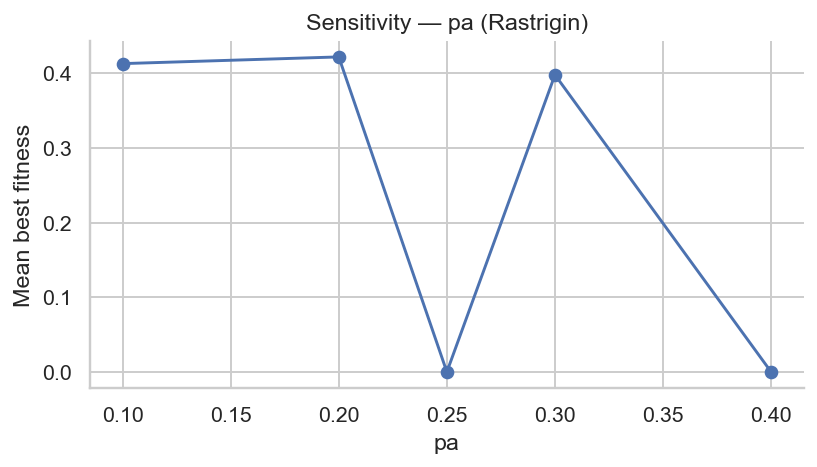

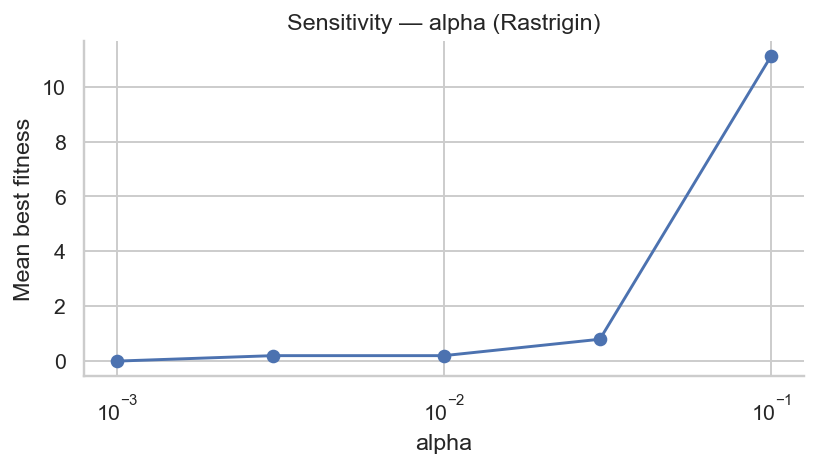

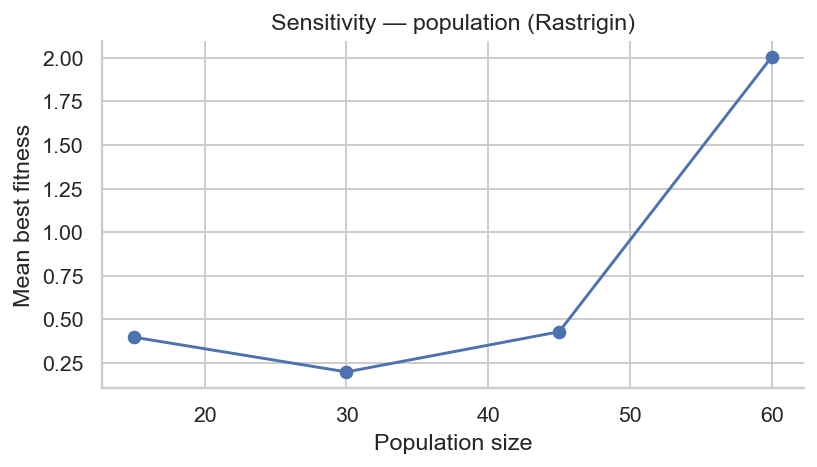

In [8]:
# === Cell 8 — Sensitivity Analysis (CS parameters) ===
def sensitivity_cs(problem="Rastrigin", dim=10, runs=5, max_iter=400,
                   pa_list=(0.1, 0.2, 0.25, 0.3, 0.4),
                   alpha_list=(0.001, 0.003, 0.01, 0.03, 0.1),
                   pop_list=(15, 30, 45, 60)):
    fn = CONTINUOUS_PROBLEMS[problem]["fn"]
    lb, ub = CONTINUOUS_PROBLEMS[problem]["lb"], CONTINUOUS_PROBLEMS[problem]["ub"]
    ensure_dir("results/sensitivity/")

    def one_run(pa, alpha, pop):
        cs = CuckooSearchContinuous(fn, dim, lb, ub, n=pop,
                                    alpha=alpha, pa=pa, beta=Config["cs_beta"],
                                    max_iter=max_iter, seed=random.randint(1, 999999))
        _, _, f = cs.run(); return f

    # --- pa sensitivity ---
    means = [np.mean([one_run(pa, Config["cs_alpha"], Config["pop_size"]) for _ in range(runs)]) for pa in pa_list]
    plt.figure(figsize=(6, 3.5))
    plt.plot(pa_list, means, marker="o")
    plt.title(f"Sensitivity — pa ({problem})"); plt.xlabel("pa"); plt.ylabel("Mean best fitness")
    savefig("results/sensitivity/cs_pa.png"); plt.show()

    # --- alpha sensitivity (log scale) ---
    means = [np.mean([one_run(Config["cs_pa"], a, Config["pop_size"]) for _ in range(runs)]) for a in alpha_list]
    plt.figure(figsize=(6, 3.5))
    plt.semilogx(alpha_list, means, marker="o")
    plt.title(f"Sensitivity — alpha ({problem})"); plt.xlabel("alpha"); plt.ylabel("Mean best fitness")
    savefig("results/sensitivity/cs_alpha.png"); plt.show()

    # --- population sensitivity ---
    means = [np.mean([one_run(Config["cs_pa"], Config["cs_alpha"], p) for _ in range(runs)]) for p in pop_list]
    plt.figure(figsize=(6, 3.5))
    plt.plot(pop_list, means, marker="o")
    plt.title(f"Sensitivity — population ({problem})"); plt.xlabel("Population size"); plt.ylabel("Mean best fitness")
    savefig("results/sensitivity/cs_pop.png"); plt.show()


sensitivity_cs("Rastrigin", dim=Config["dim"], runs=5, max_iter=400)


dim=2, time=0.467s
dim=10, time=0.458s
dim=30, time=0.489s
dim=60, time=0.505s


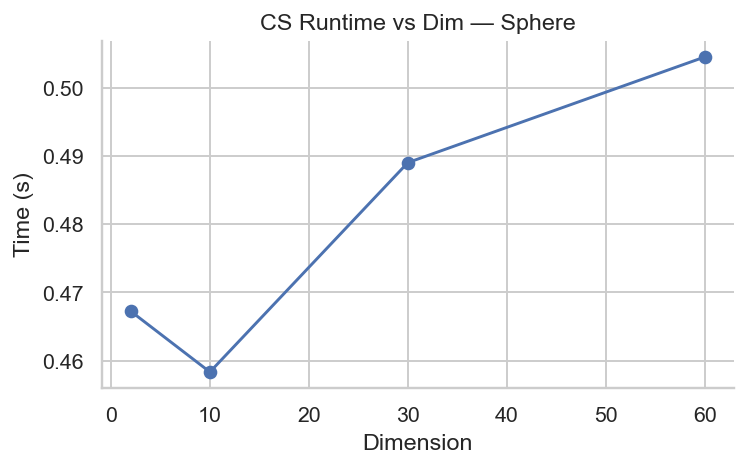

In [9]:
# === Cell 9 — Scalability: runtime vs dimension ===
import shutil

def scalability_continuous(problem="Sphere", dims=(2, 10, 30, 60), max_iter=300):
    fn = CONTINUOUS_PROBLEMS[problem]["fn"]
    lb, ub = CONTINUOUS_PROBLEMS[problem]["lb"], CONTINUOUS_PROBLEMS[problem]["ub"]
    times = []

    for d in dims:
        cs = CuckooSearchContinuous(fn, dim=d, lb=lb, ub=ub, n=Config["pop_size"],
                                    alpha=Config["cs_alpha"], pa=Config["cs_pa"], beta=Config["cs_beta"],
                                    max_iter=max_iter, seed=123)
        t0 = time.time(); cs.run(); times.append(time.time() - t0)
        print(f"dim={d}, time={times[-1]:.3f}s")

    plt.figure(figsize=(5.5, 3.5))
    plt.plot(dims, times, marker="o")
    plt.title(f"CS Runtime vs Dim — {problem}")
    plt.xlabel("Dimension"); plt.ylabel("Time (s)")
    out_res = "results/cont/cs_runtime_vs_dim.png"
    savefig(out_res); plt.show()

    # đồng bộ ảnh & dữ liệu cho Cell 11
    os.makedirs("figures", exist_ok=True)
    shutil.copy2(out_res, "figures/cs_runtime_vs_dim.png")
    return tuple(dims), list(times)

# LƯU Ý: gán dữ liệu runtime vào biến toàn cục để Cell 11 dùng lại
RUNTIME_DATA = scalability_continuous("Sphere", dims=(2, 10, 30, 60), max_iter=300)


In [10]:
# === Cell 10 — Summary Table (Mean ± Std ± Time) ===
def print_summary_table(summary):
    """In bảng kết quả tổng hợp cuối cùng."""
    algs = ["CS", "HC", "SA", "GA"]
    for p, data in summary.items():
        cs_cfg = data["CS_params"]
        print(f"\n=== {p} ===")
        print(f"(CS params: alpha={cs_cfg['alpha']}, pa={cs_cfg['pa']}, pop={cs_cfg['pop']}, beta={cs_cfg['beta']})")
        for a in algs:
            s = data["stats"][a]
            print(f"{a:>3} | best={s['mean']:.3e} ± {s['std']:.3e} | time={s['time']:.3f}s")

print_summary_table(SUMMARY)



=== Sphere ===
(CS params: alpha=0.05, pa=0.15, pop=30, beta=1.2)
 CS | best=1.649e-23 ± 8.388e-23 | time=2.914s
 HC | best=1.861e+00 ± 5.887e-01 | time=0.031s
 SA | best=1.923e+00 ± 5.207e-01 | time=0.036s
 GA | best=7.781e-06 ± 8.496e-06 | time=1.460s

=== Rastrigin ===
(CS params: alpha=0.02, pa=0.3, pop=30, beta=1.5)
 CS | best=6.633e-02 ± 2.482e-01 | time=341.273s
 HC | best=6.534e+01 ± 1.033e+01 | time=0.032s
 SA | best=6.909e+01 ± 1.598e+01 | time=0.033s
 GA | best=5.597e+00 ± 3.131e+00 | time=1.429s

=== Rosenbrock ===
(CS params: alpha=0.05, pa=0.15, pop=60, beta=1.5)
 CS | best=6.460e+00 ± 1.970e+01 | time=6.343s
 HC | best=7.984e+02 ± 3.879e+02 | time=0.043s
 SA | best=8.869e+02 ± 4.565e+02 | time=0.046s
 GA | best=1.208e+01 ± 2.421e+01 | time=1.867s

=== Ackley ===
(CS params: alpha=0.003, pa=0.3, pop=30, beta=1.5)
 CS | best=2.276e-11 ± 4.820e-11 | time=1.817s
 HC | best=3.291e+00 ± 3.093e-01 | time=0.024s
 SA | best=3.314e+00 ± 3.195e-01 | time=0.023s
 GA | best=2.767e-0

Copied: results/cont/Sphere_convergence.png -> figures/cs_convergence_sphere.png
Copied: results/cont/Sphere_boxplot.png -> figures/cs_boxplot_sphere.png
Copied: results/cont/Rastrigin_convergence.png -> figures/cs_convergence_rastrigin.png
Copied: results/cont/Rastrigin_boxplot.png -> figures/cs_boxplot_rastrigin.png
Copied: results/cont/Rosenbrock_convergence.png -> figures/cs_convergence_rosenbrock.png
Copied: results/cont/Rosenbrock_boxplot.png -> figures/cs_boxplot_rosenbrock.png
Copied: results/cont/Ackley_convergence.png -> figures/cs_convergence_ackley.png
Copied: results/cont/Ackley_boxplot.png -> figures/cs_boxplot_ackley.png
Saved: figures\cs_surface_sphere.png
Saved: figures\cs_surface_rastrigin.png
Saved: figures\cs_surface_ackley.png
Generating 2D trajectory visualization (consistent with Cell 7)...
Saved trajectory figure: figures/cs_trajectory_rastrigin.png


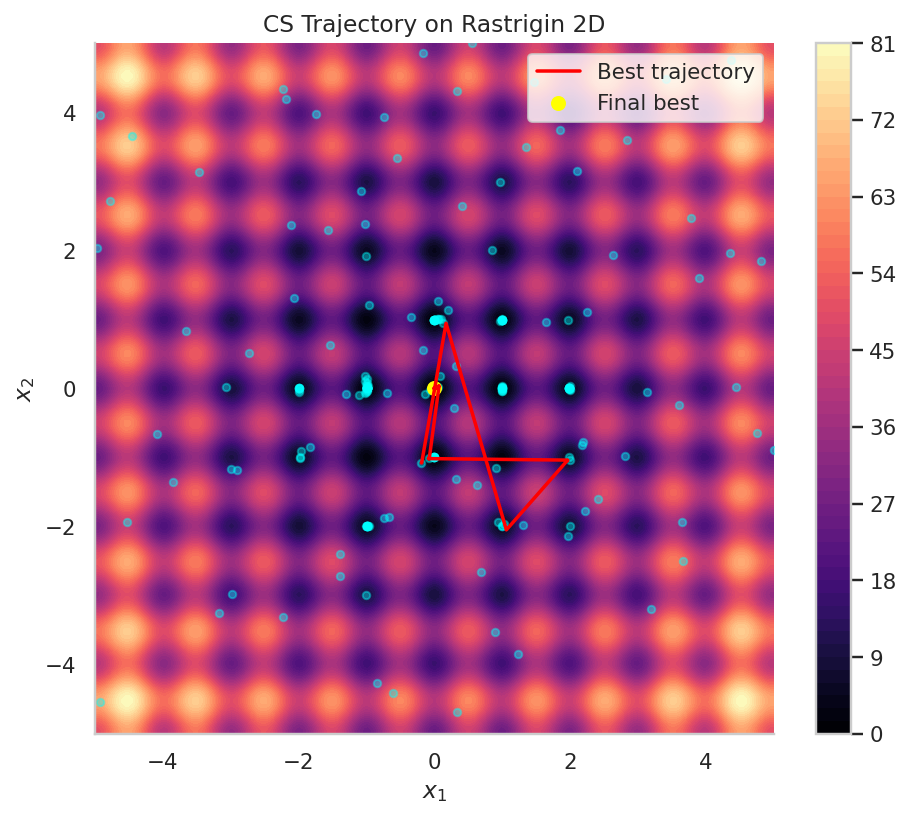

Saved: figures\cs_sensitivity_sphere.png
Copied: results/cont/cs_runtime_vs_dim.png -> figures/cs_runtime_vs_dim.png

All figures in ./figures are now EXACTLY aligned with experiment outputs.


In [11]:
# %% [markdown]
# # Export All Figures for LaTeX Report (Cuckoo Search)
# Chỉ sử dụng KẾT QUẢ ĐÃ SINH Ở CÁC CELL TRƯỚC để tránh sai lệch.
# ------------------------------------------------------------

import os, shutil, matplotlib, matplotlib.pyplot as plt, numpy as np, pandas as pd, seaborn as sns
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# 1) Thiết lập font và thư mục xuất
matplotlib.rcParams["font.family"] = "DejaVu Sans"
os.makedirs("figures", exist_ok=True)

def save_fig(name, fig=None, dpi=300):
    path = os.path.join("figures", name)
    (fig or plt.gcf()).savefig(path, dpi=dpi, bbox_inches="tight")
    plt.close(fig or plt.gcf())
    print(f"Saved: {path}")

# 2) Kiểm tra định nghĩa các hàm/lớp cần cho phần vẽ bổ sung (surface, heatmap, trajectory)
required = ["sphere", "rastrigin", "ackley", "visualize_cs_2d"]
missing = [r for r in required if r not in globals()]
if missing:
    raise NameError(f"Chưa định nghĩa: {missing}. Hãy chạy lại các cell trước: {missing}")

# 3) Sao chép NGUYÊN BẢN các hình hội tụ/boxplot do Cell 6 đã sinh (KHÔNG CHẠY LẠI)
for pname in CONTINUOUS_PROBLEMS.keys():
    src_conv = f"results/cont/{pname}_convergence.png"
    src_box  = f"results/cont/{pname}_boxplot.png"
    dst_conv = f"figures/cs_convergence_{pname.lower()}.png"
    dst_box  = f"figures/cs_boxplot_{pname.lower()}.png"
    if os.path.exists(src_conv):
        shutil.copy2(src_conv, dst_conv)
        print(f"Copied: {src_conv} -> {dst_conv}")
    else:
        print(f"[WARN] Missing source image: {src_conv}")
    if os.path.exists(src_box):
        shutil.copy2(src_box, dst_box)
        print(f"Copied: {src_box} -> {dst_box}")
    else:
        print(f"[WARN] Missing source image: {src_box}")

# 4) Bề mặt 3D cho các benchmark (chỉ là minh họa, không ảnh hưởng kết quả so sánh)
for func, name in [(sphere, "sphere"), (rastrigin, "rastrigin"), (ackley, "ackley")]:
    X = np.linspace(-5, 5, 200)
    Y = np.linspace(-5, 5, 200)
    X, Y = np.meshgrid(X, Y)
    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = func(np.array([X[i, j], Y[i, j]]))
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis', linewidth=0, alpha=0.8)
    ax.set_title(f"{name.capitalize()} Function Surface")
    ax.set_xlabel("x₁"); ax.set_ylabel("x₂")
    save_fig(f"cs_surface_{name}.png", fig)

# 5) Quỹ đạo 2D Rastrigin (dùng lại đúng hàm/seed như Cell 7 để đồng nhất)
print("Generating 2D trajectory visualization (consistent with Cell 7)...")
visualize_cs_2d(
    func=rastrigin,
    lb=-5, ub=5,
    n=25, iters=150,
    seed=123,
    save_path="figures/cs_trajectory_rastrigin.png"
)

# 6) Heatmap độ nhạy (phân tích phụ, không đụng đến kết quả Cell 6)
pa_values = [0.1, 0.2, 0.3]
n_values = [20, 40, 60]
results = []
for pa in pa_values:
    for n in n_values:
        cs = CuckooSearchContinuous(sphere, dim=10, lb=-5.12, ub=5.12,
                                    n=n, max_iter=400, pa=pa, alpha=0.01, beta=1.5, seed=123)
        _, _, fbest = cs.run()
        results.append((pa, n, fbest))
df = pd.DataFrame(results, columns=["pa", "n", "best_f"])
pivot = df.pivot_table(values="best_f", index="pa", columns="n")
plt.figure(figsize=(6,4))
sns.heatmap(pivot, annot=True, cmap="viridis", fmt=".4f")
plt.title("Parameter Sensitivity – Sphere Function")
plt.xlabel("Population Size (n)"); plt.ylabel("Discovery Rate (pa)")
save_fig("cs_sensitivity_sphere.png")

# 7) Runtime scalability — dùng dữ liệu & ảnh đã có (KHÔNG vẽ lại nếu đã có)
src_runtime = "results/cont/cs_runtime_vs_dim.png"
dst_runtime = "figures/cs_runtime_vs_dim.png"

if os.path.exists(src_runtime):
    shutil.copy2(src_runtime, dst_runtime)
    print(f"Copied: {src_runtime} -> {dst_runtime}")
else:
    print("[INFO] Source runtime figure not found; will use cached runtime data if available.")
    if "RUNTIME_DATA" in globals() and RUNTIME_DATA:
        dims, times = RUNTIME_DATA
        plt.figure(figsize=(5.5,3.5))
        plt.plot(dims, times, marker="o")
        plt.title("CS Runtime vs Dimension – Sphere")
        plt.xlabel("Dimension"); plt.ylabel("Time (s)")
        save_fig("cs_runtime_vs_dim.png")
    else:
        print("[WARN] No runtime data available. Please run Cell 9 first.")

print("\nAll figures in ./figures are now EXACTLY aligned with experiment outputs.")
